In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import utilities as util
import glob
import time
import pickle
from sklearn.ensemble import RandomForestClassifier

In [2]:
import warnings; warnings.simplefilter('ignore') #ignore the skimage warnings

In [3]:
import importlib
importlib.reload(util);

In [4]:
def load_images(files):
    images = []
    for i, f in enumerate(files):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images    
    
test_images = load_images(sorted(glob.glob("./test_images/*.jpg")))
car_images = load_images(sorted(glob.glob("./vehicles/*/*.png")))
noncar_images = load_images(sorted(glob.glob("./non-vehicles/*/*.png")))
print ("number of car images:", len(car_images))
print ("number of non-car images:", len(noncar_images))


number of car images: 8792
number of non-car images: 8968


# Exploring the dataset and features

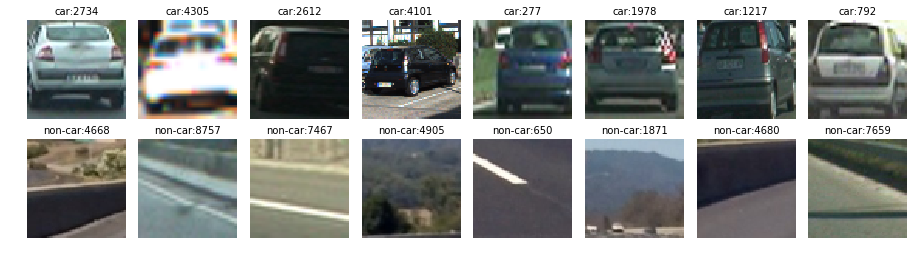

In [5]:
def rand_car():
    return np.random.randint(0,len(car_images))
def rand_noncar():
    return np.random.randint(0,len(noncar_images))
    
#randomly show some pictures in the dataset
fig, axs = plt.subplots(2,8, figsize=(16, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(8):
    n = rand_car()
    img = car_images[n]
    axs[i].axis('off')
    axs[i].set_title('car:'+str(n), fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    n = rand_noncar()
    img = noncar_images[n]
    axs[i].axis('off')
    axs[i].set_title('non-car:'+str(n), fontsize=10)
    axs[i].imshow(img)
plt.show()    

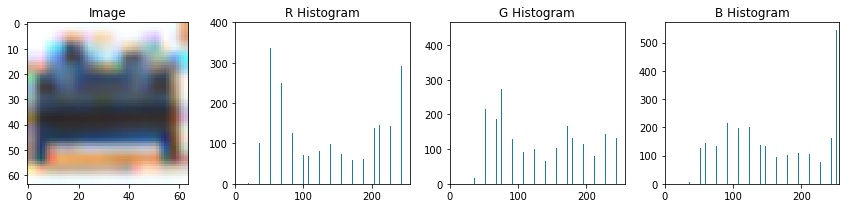

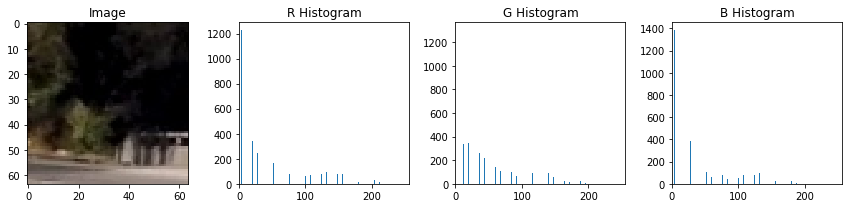

In [6]:
# show color histogram in RGB space
hist = util.ColorHist(car_images[rand_car()])
hist.show()
plt.show()
hist = util.ColorHist(noncar_images[rand_noncar()])
hist.show()
plt.show()

The distribution of the Histogram are very different for car and not-car images. This indicates this might be a good feature to tell car or not-car images.
Next I converted the image into YCrCb space and plot the pixel distribution in both RGB and YCbCr space. 

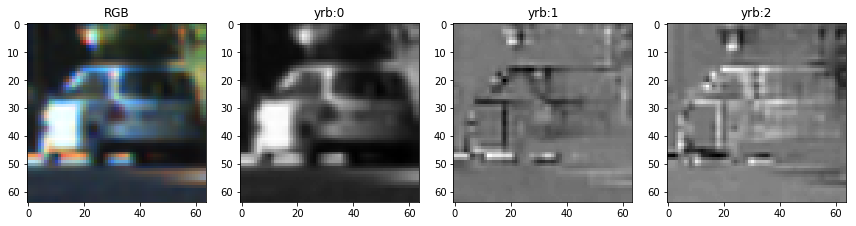

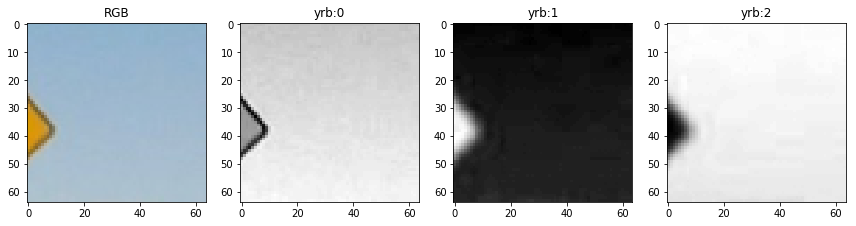

In [7]:
cspace = 'yrb'
cs_img0 = util.ColorSpace(car_images[rand_car()],cspace)
cs_img0.show()
plt.show()

cs_img1 = util.ColorSpace(noncar_images[rand_noncar()],cspace)
cs_img1.show()
plt.show()

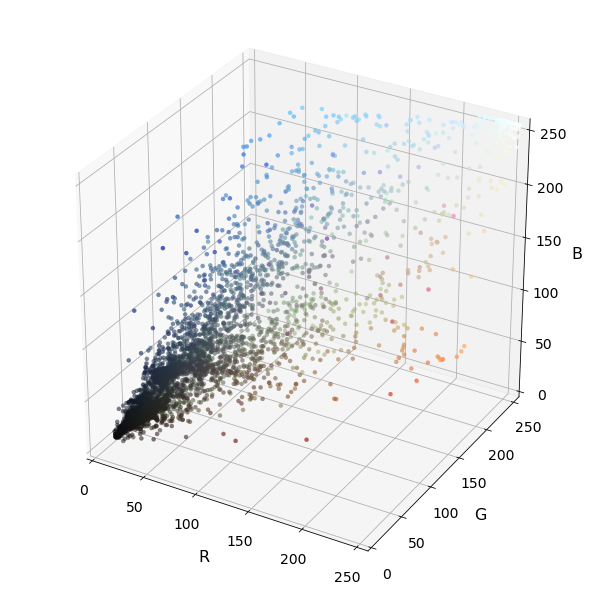

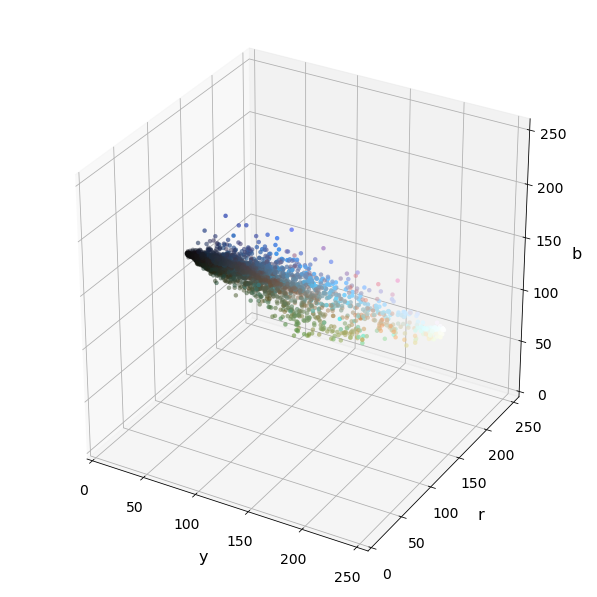

In [8]:
cs_img0.plot_color_3d()

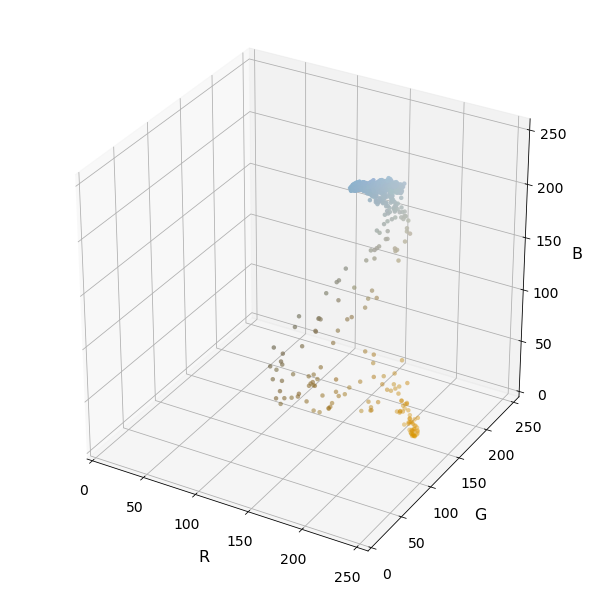

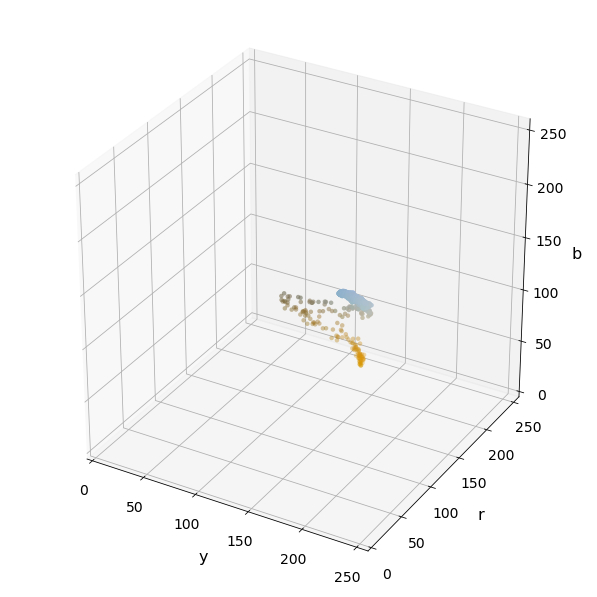

In [10]:
cs_img1.plot_color_3d()

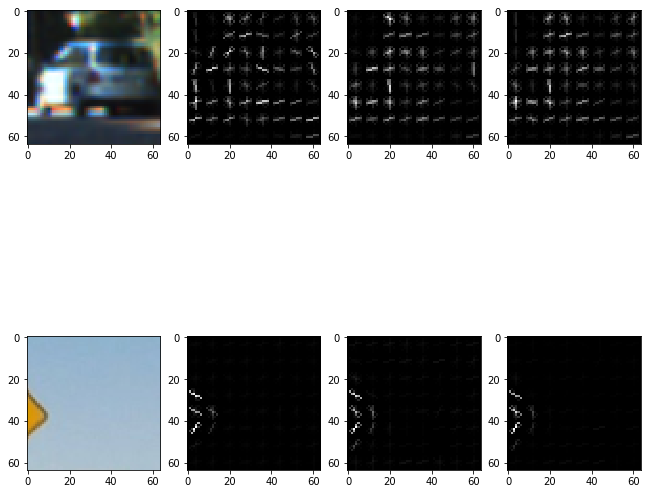

In [11]:
# get the HOG features for each channel of a given image, then displace them
def get_hog(img, hog_list):
    for i in range(3):
        _, hog = util.get_hog_features(img[:,:,i], 11, 8, 2, vis=True, feature_vec=False)
        hog_list.append(hog)
        
car_hog = []
notcar_hog = []

get_hog(cs_img0.cvt_img, car_hog)
get_hog(cs_img1.cvt_img, notcar_hog)

f, axs = plt.subplots(2, 4, figsize=(11,11))
f.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

i= 0
axs[i].imshow(cs_img0.img)
for hog in car_hog:
    i += 1
    axs[i].imshow(hog, cmap='gray')
    
i=4
axs[i].imshow(cs_img1.img)
for hog in notcar_hog:
    i += 1
    axs[i].imshow(hog, cmap='gray')
plt.show()


Here we can see the HOG in all the 3 channels are very different for Car and NotCar images. It's not so sensitive to the color, size, position of the car (and not-car) in the image.

# Extract Features from the dataset

In [12]:
def extract_features(imgs, color_space='hls', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        file_features = []
        # Read in each one by one
        img = util.ColorSpace(img, color_space).cvt_img;
        if spatial_feat == True:
            spatial_features = util.bin_spatial(img, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = util.ColorHist(img, nbins=hist_bins).hist_features
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(img.shape[2]):
                    hog_features.append(util.get_hog_features(img[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = util.get_hog_features(img[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [13]:
# Define parameters for feature extraction
#color_space = 'hls' 
color_space = 'yrb' 
orient = 11  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#hog_channel = 2 # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
spatial_size = () # Spatial binning dimensions
#hist_bins = 0    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_bins = 32    # Number of histogram bins
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [14]:
from sklearn.preprocessing import StandardScaler

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ("feature vector length:", len(car_features[0]))
print ('# of car samples: ', len(car_features))
noncar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ('# of Non-car samples: ', len(noncar_features))


feature vector length: 1284
# of car samples:  8792
# of Non-car samples:  8968


In [199]:
#save a check point
pickle.dump(car_features, open('./car_features_hog.p', 'wb'))
pickle.dump(noncar_features, open('./noncar_f"eatures_hog.p', 'wb'))


# Train the model
I use Linear SVC as the model.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC


X = np.vstack((car_features, noncar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X
pickle.dump(X_scaler, open('./x_scaler_hog.p','wb'))

Split the training and validation set, generate the labels, and train the model

In [145]:

y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

#print('Using:',orient,'orientations', pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Training vector length:', X_train.shape[0])

#clf = LinearSVC(loss='hinge') # Use a linear SVC 
clf = RandomForestClassifier()#random_state=0)
t=time.time() # Check the training time for the SVC
clf.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print("Training Time(sec) :", round(t2-t, 2))
print('Test Accuracy :', round(clf.score(X_test, y_test), 4)) 

Training vector length: 14208
Training Time(sec) : 0.91
Test Accuracy : 0.993


In [200]:
from sklearn.externals import joblib
joblib.dump(clf, 'svc_hog.pkl') 

['svc_hog.pkl']

# Checkpoint

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [24]:
from sklearn.externals import joblib
clf = joblib.load('svc_hog.pkl') 
X_scaler = pickle.load(open('x_scaler_hog.p', 'rb'))

In [25]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# can also enable color histogram and color bins features
# must match with the features used in training.
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,all_rectangles=None):
    
    # array of rectangles of searched windows. 
    rectangles = []
    #prediction result for each searching window. 1 means car detected
    predictions = []
    
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    ctrans_tosearch = util.ColorSpace(img_tosearch, cspace).cvt_img
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = util.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = util.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = util.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            test_features = hog_features

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            if spatial_size or hist_bins!=0:
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                if hist_bins != 0:    
                    hist_features = util.ColorHist(subimg, nbins=hist_bins).hist_features
                    #test_features = np.hstack((hist_features, test_features))
                    test_features = np.concatenate([hist_features, test_features])
                if spatial_size:
                    spatial_features = util.bin_spatial(subimg, size=spatial_size)
                    #test_features = np.hstack((spatial_features, test_features))
                    test_features = np.concatenate([spatial_features, test_features])
                #test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                #test_features = test_features.reshape(1, -1)
            else:
                test_features = hog_features
            test_features = X_scaler.transform(test_features)    
                
            test_prediction = svc.predict(test_features)
           
            # store the current window and preditecion result
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            if test_prediction:
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            if all_rectangles is not None:
                all_rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    

# Searching Window
Next is to explore the searching windows' position and size by using the trained model.
The base size is 64x64, and in the middle of the image. Then I scaled the window by 1, 1.5, 2, 3 while moving the windows position toward the camera. 

Here are some results:

In [26]:
test_img = test_images[5]

total positive predictions: 1


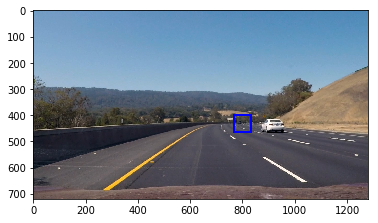

In [27]:
ystart = 400
ystop = 528
scale = 1.0

rects = find_cars(test_img, ystart, ystop, scale, 
                       color_space, hog_channel, clf, X_scaler, 
                       orient, pix_per_cell, cell_per_block, 
                       spatial_size, hist_bins)
print ('total positive predictions:', len(rects))
img = util.draw_boxes(test_img, rects)
plt.imshow(img)
plt.show()

total positive predictions: 1


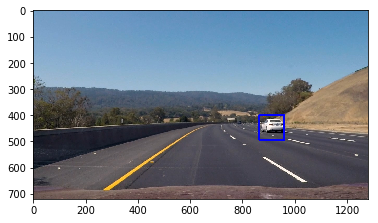

In [28]:
ystart = 400
ystop = 528
scale = 1.5

rects = find_cars(test_img, ystart, ystop, scale, 
                       color_space, hog_channel, clf, X_scaler, 
                       orient, pix_per_cell, cell_per_block, 
                       spatial_size, hist_bins)
print ('total positive predictions:', len(rects))
img = util.draw_boxes(test_img, rects)
plt.imshow(img)
plt.show()

total positive predictions: 0


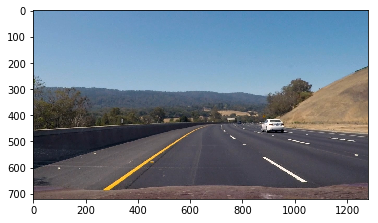

In [29]:
ystart = 400
ystop = 596
scale = 2.0
s_rects=[]
rects = find_cars(test_img, ystart, ystop, scale, 
                       color_space, hog_channel, clf, X_scaler, 
                       orient, pix_per_cell, cell_per_block, 
                       spatial_size, hist_bins,s_rects)
print ('total positive predictions:', len(rects))
img = util.draw_boxes(test_img, rects)
plt.imshow(img)
plt.show()

total positive predictions: 0


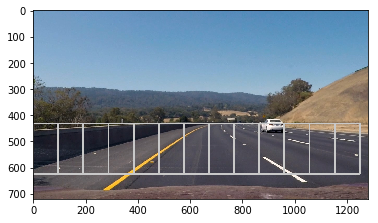

In [30]:
ystart = 432
ystop = 660
scale = 3.0
all_rects=[]
rects = find_cars(test_img, ystart, ystop, scale, 
                       color_space, hog_channel, clf, X_scaler, 
                       orient, pix_per_cell, cell_per_block, 
                       spatial_size, hist_bins, all_rects)
print ('total positive predictions:', len(rects))
img = util.draw_boxes(test_img, rects)
img = util.draw_boxes(img,  all_rects, color=(200, 200, 200))
plt.imshow(img)
plt.show()

Based on upper experiment, I make a list of searching areas, along with the window size.

In [31]:
#search_areas = ((400,528), (400,528), (400,596), (400, 596), (432, 660))
#scales = (1.0, 1.5, 2.0, 2.5, 3.0)
search_areas = ((400,528), (416, 480), (400,528), (400, 596), (432, 660))
scales = (1.0, 1.0, 1.5, 2.0, 3.0)
def find_cars_all(in_img):
    rects_all = []
    for a, s in zip(search_areas, scales):
        rects = find_cars(in_img, a[0], a[1], s, 
                           color_space, hog_channel, clf, X_scaler, 
                           orient, pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
        rects_all.extend(rects)
    return rects_all


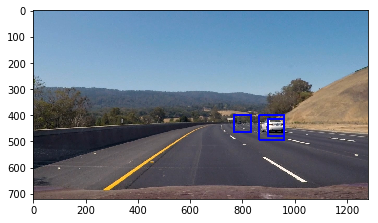

3


In [32]:
rects_all = find_cars_all(test_img)
img = util.draw_boxes(test_img, rects_all, in_place=False)
plt.imshow(img)
plt.show()
print (len(rects_all))

# Heatmap
Use heatmap to label the blocks that detect a car.

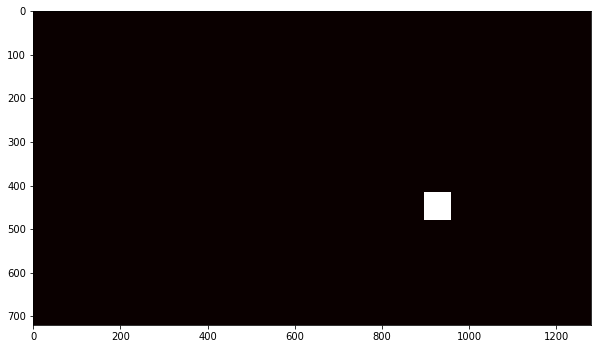

In [33]:
# Test out the heatmap
heatmap=np.zeros_like(test_img[:,:,0])
heatmap_img = util.add_heat(heatmap,rects_all,1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

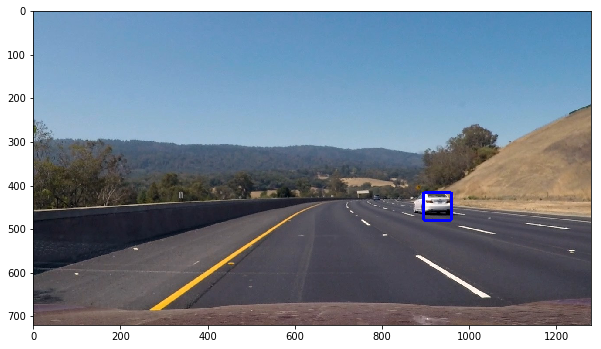

In [34]:
# Draw bounding boxes on a copy of the image
draw_img, rect = util.draw_labeled_bboxes(np.copy(test_img), heatmap_img)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.show()

In [35]:
def image_process(in_img,heatmap, th=1):
    rects_all = find_cars_all(in_img)
    heatmap = util.add_heat(heatmap,rects_all,th)
    img, l_rects = util.draw_labeled_bboxes(in_img, heatmap)
    return img, rects_all

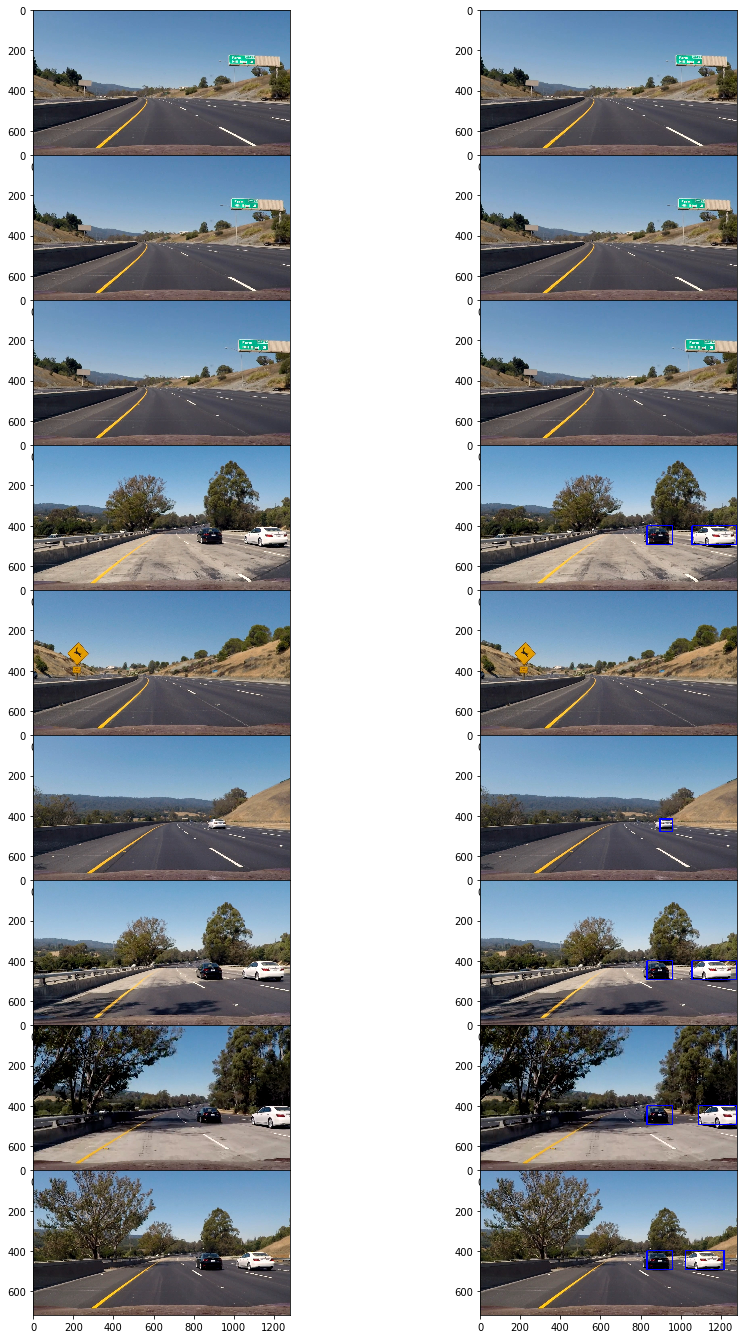

In [39]:
fig, axs = plt.subplots(9, 2, figsize=(16,24))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    heatmap = np.zeros_like(im[:,:,0])
    img, _= image_process(np.copy(im), heatmap, 1)
    axs[2*i].imshow(im)
    axs[2*i+1].imshow(img)
    #axs[i].axis('off')
plt.show()                  

# Process the video
For each image of the video, process the image similiarly as what img_process() does. I did not use img_process() directly because I want to tune the process in the video process directly.

In [51]:
from functools import reduce
class CarDetect:
    def __init__(self):
        self.rects_frames=[]
    def add_rects(self, rects):
        #if len(rects) > 0:   
        #    self.rects_frames.extend(rects)
        #if len(self.rects_frames) > 18:
        #    self.rects_frames = self.rects_frames[len(self.rects_frames)-18:]
        if len(self.rects_frames)>=6:
            self.rects_frames.pop(0)
        self.rects_frames.append(rects)
            
car_dec = CarDetect()            
frame_cnt = 0
def video_process(img):
    global frame_cnt
    heatmap = np.zeros_like(img[:,:,0])
    rects = find_cars_all(img)
    car_dec.add_rects(rects)
    #print ("frame:{} detects:{} history:{}".format(frame_cnt, len(rects), len(car_dec.rects_frames)))
    dump = False
    if dump and len(rects) != 0:
        cv2.imwrite('detect_img_'+str(frame_cnt)+'.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    #heatmap = util.add_heat(heatmap,car_dec.rects_frames,min(len(car_dec.rects_frames)//2, 2))
    all_rects = reduce(lambda x,y: x+y, car_dec.rects_frames)
    heatmap = util.add_heat(heatmap,all_rects, min(len(all_rects)//2+1, 5))
    out_img, l_rects = util.draw_labeled_bboxes(img, heatmap)
    #img, l_rects = image_process(img, heatmap, 3)
    frame_cnt += 1
    return out_img
    

In [52]:
from moviepy.editor import VideoFileClip
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')#.subclip(20, 22)
#clip_test = VideoFileClip('test_video.mp4')
frame_cnt = 0
clip_test_out = clip_test.fl_image(video_process)

%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:39<00:00,  2.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 12min 25s, sys: 2.34 s, total: 12min 27s
Wall time: 8min 40s
